# Préparation

## Librairies

Importer ces librairies qui auront préalablement ajoutées à l'environnement de travail activé (soit dans un environnement local, soit dans le document _environment.yml_ dans Binder.

In [1]:
import json
import pprint
from collections import Counter
from operator import itemgetter
import csv

In [2]:
# https://github.com/drgrib/dotmap
from dotmap import DotMap

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [341]:
# Non utilisées pour l'instant dans ce carnet
# import jdcal as jd
# import datetime


## Fonction locales

In [15]:
# Fonction de nettoyage
def clean_up_str(string):
    a = ''
    if string:
        a = string.replace('\xa0', '').replace('  ', ' ').strip()
    return a    

# Préparation des données à analyser

## Ourvir et inspecter le fichier

Ce fichier contient le résultat d'une requête effectuée dans Geovistory, une table dans le domaine Analysis, ayant le même nom, effectuée à la date indiquée dans le nom du fichier. Si on souhaite utiliser un nouveau fichier, contenant de nouvelles données, il faut le télécharger depuis Geovistory vers le dossier *geovistory_query_exports* et indiquer l'adresse correcte dans la cellule suivante

In [344]:
file = 'geovistory_query_exports/aq_stato_civile_20210827.json'

In [349]:
### Ouvrir le fichier et le mettre dans la variable *data* sous forme de dictionnaire Python
with open(file) as json_file:
    data = json.load(json_file)
print(type(data), '\n-----')
# noms des objets racine du fichier JSON
z = [print(a) for a in data]

<class 'dict'> 
-----
columns
rows


In [350]:
### Nombre de lignes dans le fichier, 
# elles correspondent aux lignes du tableau 
# résultant de la requête dans Geovistory
rows = data['rows']
len(rows)

5645

In [353]:
### Les noms des colonnes issues de la requête dans Geovistory
columns = data['columns']
pprint.pprint(columns)

{'col_0': 'Entity Preview',
 'col_1': 'Gender',
 'col_10': 'Witness date(s)',
 'col_11': 'Witness in enquiry of type',
 'col_12': 'Real identity',
 'col_13': 'Union Date',
 'col_2': 'Birth',
 'col_3': 'Occupation Date',
 'col_4': 'Occupation Type',
 'col_5': 'Origin',
 'col_6': 'Pre-matrimonial Enquiry',
 'col_7': 'Pre-matrimonial Enquiry Date',
 'col_8': 'Pre-matrimonial Enquiry Type',
 'col_9': 'Witness'}


In [ ]:
### Afficher deux lignes du tableau
# et explorer les objets qui représentent les cellules
# du tableau pour chaque colonne
[pprint.pprint(r) for r in rows[99:101]]

In [91]:
### Créer un objet DotMap afin de faciliter l'exploitation
dm_data = DotMap(data)

In [354]:
### Créer une variable contenant les lignes
dm_r = dm_data.rows
### L'effectif des lignes
len(dm_r)

5630

## Transformation et mise à plat des données

Il est nécessaire de disposer de données agrégées et mises à plat (en supprimant notamment les valeurs multiples pour une seule variable) afin de pouvoir effectuer les analyses.

In [355]:
### Persons list = pl
#   liste de personnes agrégéées et propriétés mises à plat

pl = [['id_persona','nome','anno_nascita','genere','luogo_origine','mestieri',\
       'numero_processetti','id_primo_processetto','anno_primo_processetto','tipo_primo_processetto',\
       'numero_testimonianze','id_prima_testimonianza','anno_prima_testimonianza','tipo_prima_testimonianza',\
       'date_unions']]

for r in dm_r: # [60:90]
    element = []
    # personne
    element += [r.col_0.entity.pk_entity, clean_up_str(r.col_0.entity.entity_label)]
    values = []
    # annee naissance
    for v in r.col_2['values']:
        if v.value.timePrimitive:
            values.append(int(v.value.timePrimitive['from'].calGregorian[:4]))
    if len(values) > 1:
        element += [int(round(np.rint(np.mean(values))))]
    elif len(values) > 0:    
        element += [values[0]]
    else:
        element += [None]
        
    # genre    
    element += [r.col_1.entities[0].entity_label if r.col_1.entities else 'missing']

    # origine(s)
    element += ['#'.join([clean_up_str(p.entity_label) + '('+ str(p.pk_entity) +')' for p in r.col_5.entities])]

    # metier(s)
    element += ['#'.join([clean_up_str(p.entity_label) + '('+ str(p.pk_entity) +')' for p in r.col_4.entities])]
    # element += [clean_up_str(p.entity_label) + '('+ str(p.pk_entity) +')' for p in r.col_4.entities]
    pl.append(element)
    
    # nombre processetti + id premier processetto
    if len(r.col_6.entities) > 0:
        element += [len(r.col_6.entities)]
        element += [[v.pk_entity for v in r.col_6.entities][0]]
    else:
        element += [0]
        element += [0]
        
    # annee premier processetto
    values = []
    for v in r.col_7['values']:
        if v.value.timePrimitive:
            values.append(int(v.value.timePrimitive['from'].calGregorian[:4]))
            values.append(int(v.value.timePrimitive['to'].calGregorian[:4]))
    if len(values) > 1:
        element += [int(round(np.rint(np.mean(values))))]
    elif len(values) > 0:    
        element += [values[0]]
    else:
        element += [None]
        
    # types premier processetto
    if len(r.col_8.entities) > 0:
        element += ['#'.join([v.entity_label for v in r.col_8.entities])]
    else:
        element += ['']
    
        
    
    # nombre testimone + id premier processetto testimone
    if len(r.col_9.entities) > 0:
        element += [len(r.col_9.entities)]
        element += [[v.pk_entity for v in r.col_9.entities][0]]
    else:
        element += [0]
        element += [0]
        
    # annee premier processetto testimone
    values = []
    for v in r.col_10['values']:
        if v.value.timePrimitive:
            values.append(int(v.value.timePrimitive['from'].calGregorian[:4]))
            values.append(int(v.value.timePrimitive['to'].calGregorian[:4]))
    if len(values) > 1:
        element += [int(round(np.rint(np.mean(values))))]
    elif len(values) > 0:    
        element += [values[0]]
    else:
        element += [None]

    # types processetto comme contexte de témoignage
    if len(r.col_11.entities) > 0:
        element += ['#'.join([v.entity_label for v in r.col_11.entities])]
    else:
        element += ['']
        
    # Union
    values = []
    for v in r.col_13['values']:
        if v.value.timePrimitive:
            values.append(int(v.value.timePrimitive['from'].calGregorian[:4]))
            values.append(int(v.value.timePrimitive['to'].calGregorian[:4]))
    if len(values) > 1:
        element += [int(round(np.rint(np.mean(values))))]
    elif len(values) > 0:    
        element += [values[0]]
    else:
        element += [None]
    

In [ ]:
### Inspection des données produites
pl[:3]

In [357]:
### Transformation en DataFrame et export vers un fichier CSV
# Ce fichier pourra être exploré et manipulé dans un tableur, si souhaité
pl_df = pd.DataFrame(pl[1:], columns=pl[0])
file_exp = 'geovistory_query_exports/demographie.csv'
pl_df.to_csv(file_exp, sep='|')
print('Effectif :', len(pl_df), '\n')
pl_df.head()

Effectif : 5630 



,id_persona,nome,anno_nascita,genere,luogo_origine,mestieri,numero_processetti,id_primo_processetto,anno_primo_processetto,tipo_primo_processetto,numero_testimonianze,id_prima_testimonianza,anno_prima_testimonianza,tipo_prima_testimonianza,date_unions
0,81417,Tommaso di Lorenzo Spilman (tedesco),1558.0,Maschile,Alemania(753623),,0,0,NaN,,1,739330,1592.0,Stato libero di “foresto” #Processetto atipico,NaN
1,81461,Gieremia Vais,NaN,Maschile,,,0,0,NaN,,0,0,NaN,,NaN
2,81648,"Limoletti, Domenico",NaN,Maschile,,,0,0,NaN,,0,0,NaN,,NaN
3,737969,Maestro Venere (Padova),NaN,Maschile,,,0,0,NaN,,0,0,NaN,,NaN
4,737986,Giacomo di Cristoforo Franes (da Füssen),1566.0,Maschile,Füssen(1082004),,1,739330,1592.0,Stato libero di “foresto” #Processetto atipico,0,0,NaN,,1592.0


# Analyse

## Effectifs de requérants / témoignages et distribution dans le temps

### Effectifs généraux

In [359]:
### Effectif personnes ayant été objets d'un processetto
len(pl_df[pl_df['id_primo_processetto']>0])

1788

In [360]:
### Effectif personnes ayant témoigné lors d'un processetto
len(pl_df[pl_df['id_prima_testimonianza']>0])

3559

### Distribution dans le temps

In [362]:
print(pl_df['anno_primo_processetto'].sort_values().head(), pl_df['anno_prima_testimonianza'].tail(), '\n-----')
pl_df['anno_primo_processetto'].describe()

5532    1061.0
4       1592.0
1158    1592.0
326     1592.0
1155    1592.0
Name: anno_primo_processetto, dtype: float64 5625       NaN
5626    1600.0
5627       NaN
5628    1603.0
5629    1603.0
Name: anno_prima_testimonianza, dtype: float64 
-----


count    1784.000000
mean     1599.799327
std        14.932568
min      1061.000000
25%      1597.000000
50%      1598.000000
75%      1602.000000
max      1693.000000
Name: anno_primo_processetto, dtype: float64

### Age

Ajout d'une colonne contenant l'age des personnes au moment du processetto. Noter qu'il s'agit de moyenne en raison de la mise à plat et lissage des données opéré ci-dessus

In [363]:
pl_df['anno_primo_processetto'] = pl_df['anno_primo_processetto'].fillna(0)
pl_df['anno_prima_testimonianza'] = pl_df['anno_prima_testimonianza'].fillna(0)

In [364]:
pl_df['eta'] = pl_df['anno_primo_processetto'] + pl_df['anno_prima_testimonianza'] - pl_df['anno_nascita']
pl_df['eta'] = pl_df['eta'].fillna(0)

In [365]:
pl_df[['eta','anno_nascita','anno_primo_processetto','anno_prima_testimonianza']].iloc[30:35]

,eta,anno_nascita,anno_primo_processetto,anno_prima_testimonianza
30,50.0,1548.0,0.0,1598.0
31,51.0,1547.0,0.0,1598.0
32,0.0,NaN,0.0,0.0
33,30.0,1562.0,1592.0,0.0
34,0.0,NaN,0.0,0.0


In [366]:
### Ce calcul des valeurs de centralité et dispersion est biaisée par quelques erreurs 
# de saisie et données manquantes
pl_df['eta'].describe()

count    5630.000000
mean       12.885613
std       260.647814
min     -1696.000000
25%        23.000000
50%        30.000000
75%        40.000000
max      1654.000000
Name: eta, dtype: float64

In [221]:
### la valeur médiane est 32 ans
pd.Series([int(e) for e in list(pl_df['eta']) if e > 0 and e < 100]).describe()

count    4864.000000
mean       34.962993
std        12.561552
min         5.000000
25%        25.000000
50%        32.000000
75%        42.000000
max        98.000000
dtype: float64

## Nettoyage et codage des données 

Le tableau produit simplifie et uniformise les données en vue de l'analyse

In [372]:
liste_annees = pd.RangeIndex(1592, 1694).to_series()
liste_annees.tail().values

array([1689, 1690, 1691, 1692, 1693])

In [373]:
##  https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
result_list = []
for l in liste_annees:  # [:2]
    for (i,row) in pl_df.iterrows():   # .iloc[:100]
        # print(l, row['anno_primo_processetto'])
        if l == row['anno_primo_processetto']:
            if 'atipico' in row['tipo_primo_processetto']:
                proc_type = 'atipico'
            elif 'Vedovanza' in row['tipo_primo_processetto']:
                proc_type = 'vedovanza'
            elif 'assente' in row['tipo_primo_processetto']:
                proc_type = 'assente'
            elif 'libero' in row['tipo_primo_processetto']:
                proc_type = 'libero'
            else:
                proc_type = 'manca'
            result_list.append([l, 'richiedente', proc_type, row['genere'], int(row['eta'])])

        if l == row['anno_prima_testimonianza']:
            if 'atipico' in row['tipo_prima_testimonianza']:
                proc_type = 'atipico'
            elif 'Vedovanza' in row['tipo_prima_testimonianza']:
                proc_type = 'vedovanza'
            elif 'assente' in row['tipo_prima_testimonianza']:
                proc_type = 'assente'
            elif 'libero' in row['tipo_prima_testimonianza']:
                proc_type = 'libero'
            else:
                proc_type = 'manca'

            result_list.append([l, 'testimone', proc_type, row['genere'], int(row['eta'])])
            
                        
            

In [374]:
result_list[:10]

[[1592, 'testimone', 'atipico', 'Maschile', 34],
 [1592, 'richiedente', 'atipico', 'Maschile', 26],
 [1592, 'richiedente', 'libero', 'Maschile', 25],
 [1592, 'richiedente', 'libero', 'Maschile', 20],
 [1592, 'richiedente', 'libero', 'Maschile', 26],
 [1592, 'testimone', 'atipico', 'Maschile', 34],
 [1592, 'richiedente', 'libero', 'Maschile', 22],
 [1592, 'richiedente', 'libero', 'Maschile', 32],
 [1592, 'testimone', 'libero', 'Maschile', 29],
 [1592, 'richiedente', 'libero', 'Maschile', 38]]

In [376]:
df_result_list = pd.DataFrame(result_list, columns=['anno', 'qualita_persona', 'tipo','genere','eta'])
df_result_list.iloc[1030:1040]

,anno,qualita_persona,tipo,genere,eta
1030,1596,testimone,libero,Maschile,24
1031,1596,richiedente,libero,Maschile,20
1032,1596,testimone,libero,Maschile,51
1033,1596,testimone,libero,Maschile,56
1034,1596,richiedente,vedovanza,Femminile,0
1035,1596,testimone,vedovanza,Maschile,40
1036,1596,testimone,vedovanza,Maschile,40
1037,1596,testimone,vedovanza,Maschile,70
1038,1596,richiedente,vedovanza,Femminile,0
1039,1596,testimone,vedovanza,Maschile,56


## Regrouper les _Processetti_ par type et age

In [377]:
### Tableau de contingence age-type Processetto
# pour les personnes objet de l'enquête

X = "eta"  
Y = "tipo"

anno_tipo = df_result_list[(df_result_list['qualita_persona']=='richiedente')&(df_result_list['eta']>12)&(df_result_list['eta']<100)][[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len).fillna(0).astype(int) 
anno_tipo.iloc[1:20]

tipo,assente,atipico,libero,vedovanza
eta,,,,
15,0,0,3,0
16,0,0,8,0
17,0,0,13,0
18,2,0,26,0
19,1,2,53,0
20,0,1,86,0
21,2,1,95,0
22,0,1,105,0
23,2,1,93,0


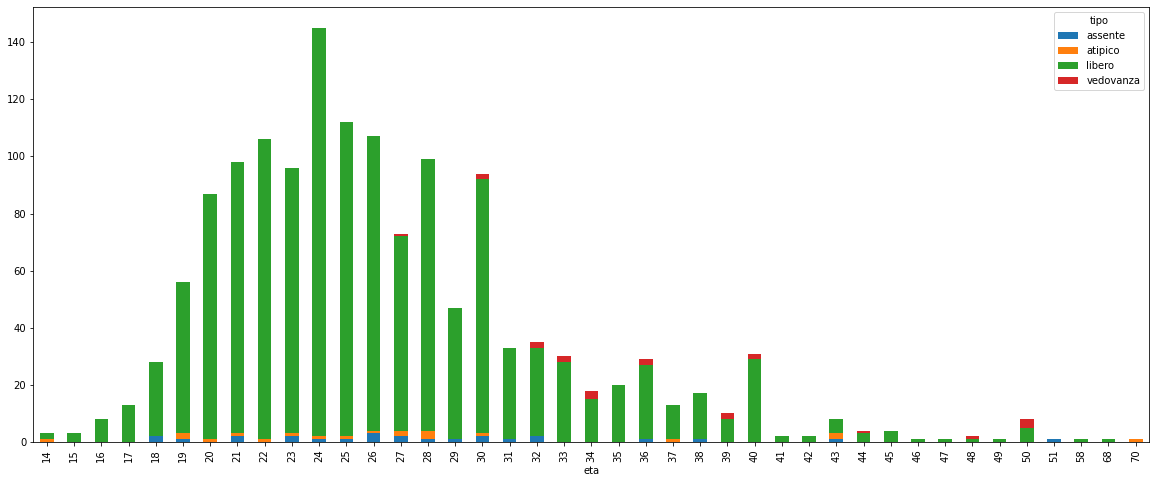

In [378]:
axis = anno_tipo.plot(kind="bar", stacked="true", figsize=(20,8))


In [379]:
### Créer la liste des périodes de 5 ans, i.e. la liste de la première année de chaque période
a5List = []
period = 5
d_start = 6
i = 0
a5List.append(d_start)

while i < 19:
    d_start = d_start + period
    a5List.append(d_start)
    i += 1

In [ ]:
print(a5List[:2])
min(a5List), max(a5List)

In [381]:
df_result_list_lustres = df_result_list.copy(deep=True)
df_result_list_lustres['lustro'] = pd.cut(df_result_list_lustres['eta'], a5List, right=False)
# Inspection
df_result_list_lustres

,anno,qualita_persona,tipo,genere,eta,lustro
0,1592,testimone,atipico,Maschile,34,"[31.0, 36.0)"
1,1592,richiedente,atipico,Maschile,26,"[26.0, 31.0)"
2,1592,richiedente,libero,Maschile,25,"[21.0, 26.0)"
3,1592,richiedente,libero,Maschile,20,"[16.0, 21.0)"
4,1592,richiedente,libero,Maschile,26,"[26.0, 31.0)"
...,...,...,...,...,...,...
5327,1628,richiedente,libero,Femminile,0,NaN
5328,1628,testimone,libero,Maschile,39,"[36.0, 41.0)"
5329,1693,richiedente,libero,Maschile,117,NaN
5330,1693,testimone,libero,Maschile,126,NaN


In [382]:
### Transformer le code ajouté pour qu'il soit plus lisible
df_result_list_lustres['lustro'] = df_result_list_lustres['lustro'].apply(lambda row : str(int(row.left))+'-'+str(int(row.right)))

In [383]:
df_result_list_lustres.head()

,anno,qualita_persona,tipo,genere,eta,lustro
0,1592,testimone,atipico,Maschile,34,31-36
1,1592,richiedente,atipico,Maschile,26,26-31
2,1592,richiedente,libero,Maschile,25,21-26
3,1592,richiedente,libero,Maschile,20,16-21
4,1592,richiedente,libero,Maschile,26,26-31


In [385]:
### Tableau de contingence lustres-typologie

X = "lustro"  
Y = "tipo"

lustro_tipo = df_result_list_lustres[(df_result_list['qualita_persona']=='richiedente')&(df_result_list_lustres['eta']>12)&(df_result_list_lustres['eta']<100)][[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len).fillna(0).astype(int) 
lustro_tipo.iloc[1:20]

tipo,assente,atipico,libero,vedovanza
lustro,,,,
16-21,3,3,186,0
21-26,6,5,546,0
26-31,9,7,401,3
31-36,3,0,126,7
36-41,2,1,91,6
41-46,1,2,16,1
46-51,0,0,9,4
51-56,1,0,0,0
56-61,0,0,1,0


In [418]:
### Tableau de contingence lustres-typologie

X = "lustro"  
Y = "tipo"

lustro_tipo = df_result_list_lustres[(df_result_list['qualita_persona']=='richiedente')&(df_result_list_lustres['eta']>12)&(df_result_list_lustres['eta']<100)][[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len).fillna(0).astype(int) 
lustro_tipo.iloc[1:20]

tipo,assente,atipico,libero,vedovanza
lustro,,,,
16-21,3,3,186,0
21-26,6,5,546,0
26-31,9,7,401,3
31-36,3,0,126,7
36-41,2,1,91,6
41-46,1,2,16,1
46-51,0,0,9,4
51-56,1,0,0,0
56-61,0,0,1,0


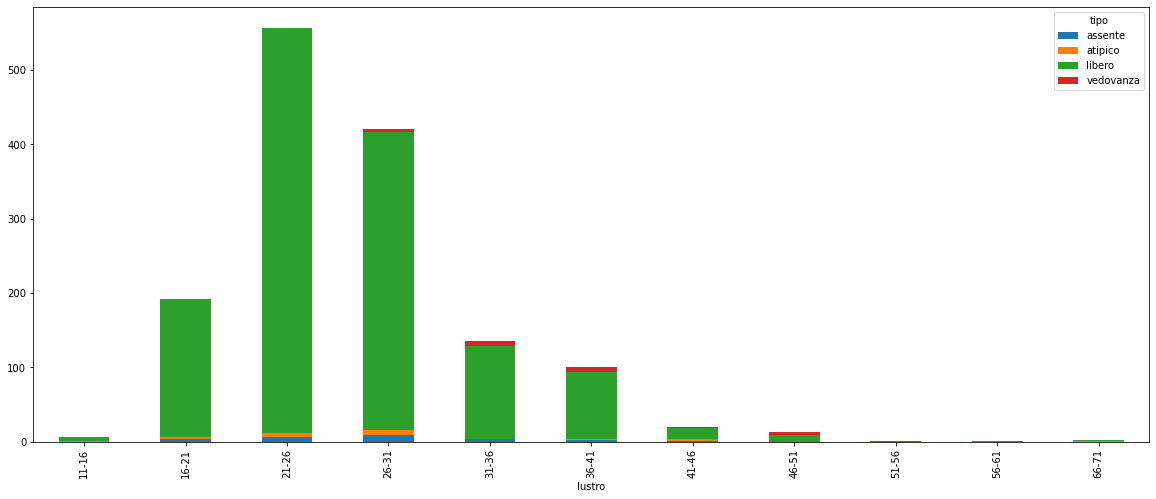

In [409]:
## https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/
axis = lustro_tipo.plot(kind="bar", stacked='true', figsize=(20,8))


### stacked bar chart Grouped
https://stackoverflow.com/questions/22787209/how-to-have-clusters-of-stacked-bars-with-python-pandas

### à faire FB : heatmap

Mettre en évidence les ages où les types de Processetto 'vedovanza' sont plus fréquents

### Témoins

In [387]:
### Tableau de contingence lustres-typologie

X = "lustro"  
Y = "tipo"

lustro_tipo_teste = df_result_list_lustres[(df_result_list['qualita_persona']=='testimone')&(df_result_list_lustres['eta']>12)&(df_result_list_lustres['eta']<100)][[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len).fillna(0).astype(int) 
lustro_tipo_teste.iloc[1:20]

tipo,assente,atipico,libero,manca,vedovanza
lustro,,,,,
16-21,0,1,71,0,15
21-26,8,2,360,0,35
26-31,6,14,507,0,50
31-36,9,16,426,0,54
36-41,7,15,515,0,65
41-46,4,4,262,0,35
46-51,6,8,295,0,37
51-56,2,4,155,0,20
56-61,4,4,171,0,20


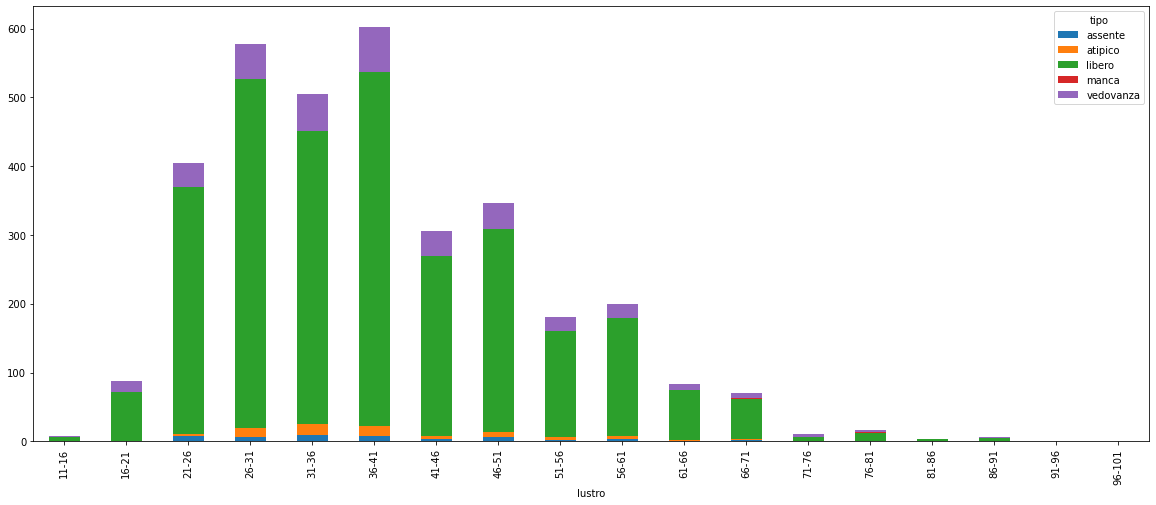

In [388]:
axis = lustro_tipo_teste.plot(kind="bar", stacked="true", figsize=(20,8))


## Distribution des genres

In [389]:
a = df_result_list.groupby('genere').size()
a.sort_values(ascending = False)

genere
Maschile     4759
Femminile     565
missing         8
dtype: int64

In [390]:
a = df_result_list[df_result_list['qualita_persona']=='richiedente'].groupby('genere').size()
a.sort_values(ascending = False)

genere
Maschile     1363
Femminile     419
missing         1
dtype: int64

In [391]:
a = df_result_list[(df_result_list['qualita_persona']=='testimone')&(df_result_list['tipo']=='libero')].groupby('genere').size()
a.sort_values(ascending = False)

genere
Maschile     2926
Femminile     100
missing         6
dtype: int64

In [404]:
### Proportion des genres dans la population
a = df_result_list[df_result_list['genere'] != 'missing'].groupby('genere').size()
[v/sum(a.values)*100 for v in a.values]

[10.612321562734786, 89.38767843726522]

### FB à faire

* Tableau avec comparaison de ces variables
* Stacked plot



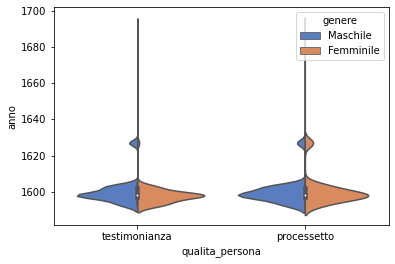

In [246]:
https://seaborn.pydata.org/generated/seaborn.violinplot.html
    ax = sns.violinplot(x="qualita_persona", y="anno", hue="genere",

                    data=df_result_list[df_result_list['genere'] != 'missing'], palette="muted", split=True)

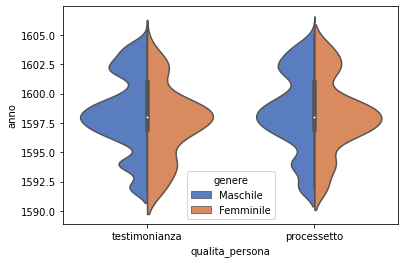

In [253]:
ax = sns.violinplot(x="qualita_persona", y="anno", hue="genere",

                    data=df_result_list[(df_result_list['genere'] != 'missing') & (df_result_list['anno'] < 1610)], palette="muted", split=True)

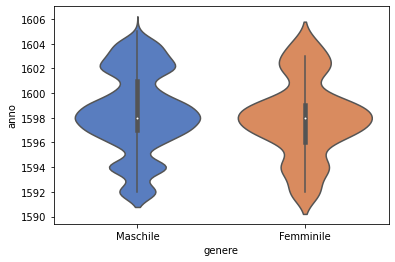

In [252]:
ax = sns.violinplot(x="genere", y="anno",

                    data=df_result_list[(df_result_list['genere'] != 'missing') & (df_result_list['anno'] < 1610)], palette="muted", split=True)

### à faire FB: Ajouter diagrammes à barre pour les genres

Représenter les données annuelles en diagramme à barres (stacked barplot) en relation avec les types de processetto

----



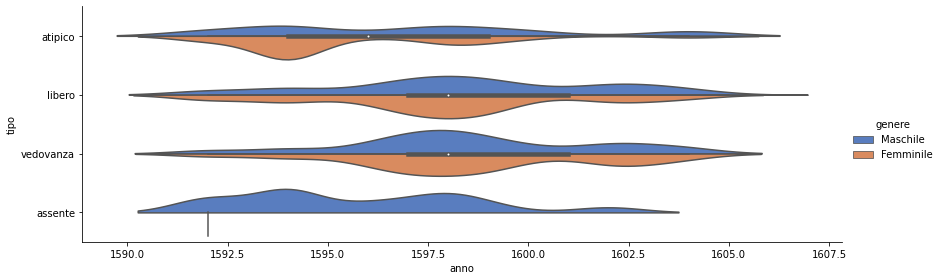

In [284]:
ax = sns.catplot(x="anno", y="tipo", hue="genere",# hue="qualita_persona", genere

                    data=df_result_list[(df_result_list['genere'] != 'missing') & (df_result_list['anno'] < 1610)], 
                    orient="h", height=4, aspect=3, 

                kind="violin",  bw=.3, palette="muted", split=True)
# dodge=True,

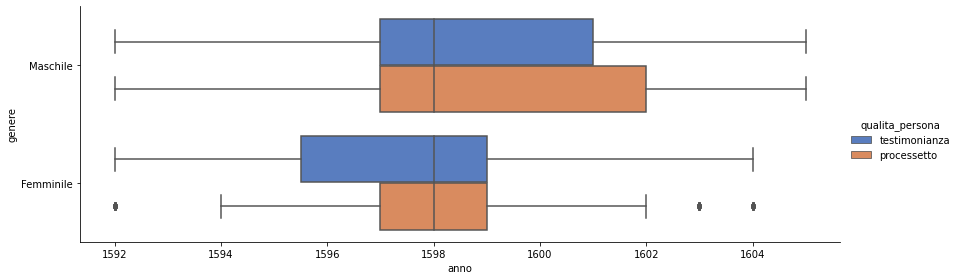

In [275]:
ax = sns.catplot(x="anno", y="tipe", hue="qualita_persona",

                    data=df_result_list[(df_result_list['genere'] != 'missing') & (df_result_list['anno'] < 1610)], 
                    orient="h", height=4, aspect=3, 

                kind="box",  palette="muted")
# dodge=True,

### Effectifs par type de processetto

In [25]:
### Regrouper par type de processetto
gb_pl_df = pl_df.groupby('tipo_primo_processetto').size()
gb_pl_df.sort_values(ascending = False)

tipo_primo_processetto
                                                                                    3844
Stato libero di “foresto”                                                           1517
Vedovanza                                                                            191
Stato libero di “foresto” #Processetto atipico                                        16
Stato libero di “foresto” #Stato libero di persona lungamente assente da Venezia      14
Processetto atipico                                                                   13
Stato libero di persona lungamente assente da Venezia                                 13
Vedovanza#Stato libero di “foresto”                                                   12
Vedovanza#Processetto atipico                                                          8
Processetto atipico #Stato libero di persona lungamente assente da Venezia             2
dtype: int64

### Nombre de processetti / témoignages par personne

Ces requêtes peuvent être utiliser pour vérifer les données

In [459]:
### Nombre de processetti par personne
# Colonnes : effectif processetti par personne, effectif personne avec cet effectif
gb_pl_df = pl_df.groupby('numero_processetti').size()
gb_pl_df.sort_values(ascending = False)

numero_processetti
0    3834
1    1777
2       2
dtype: int64

In [26]:
### Nombre de témoignages par personne
# Colonnes : effectif témoignages par personne, effectif personne avec cet effectif
gb_pl_df = pl_df.groupby('numero_testimonianze').size()
gb_pl_df.sort_values(ascending = False)

numero_testimonianze
1    3415
0    2072
2     119
3       6
4       1
dtype: int64

In [ ]:
### Nombre de processetti par personne
pl_df[pl_df['numero_testimonianze']==3]


In [ ]:
pl_df.iloc[50:60]

In [28]:
pl_df['eta'] = pl_df['anno_primo_processetto']-pl_df['anno_nascita']

In [ ]:
### Regrouper (directement, sans passer par la liste) par continent et compter avec la fonction Pandas 'groupby'
gb_pl_df = pl_df[pl_df['id_primo_processetto']>0].groupby('eta').size()
#gb_pl_df.sort_values(ascending = False)
gb_pl_df.sort_index()

In [ ]:
### Transformer l'objet Series en DataFrame et ajouter le nom de la colonne 'effectif'
# la colonne 'continent' est l'index : df_coded_nat.index
df_gb_pl_df = gb_pl_df.to_frame()
df_gb_pl_df.columns = ['effectif']
df_gb_pl_df.reset_index()

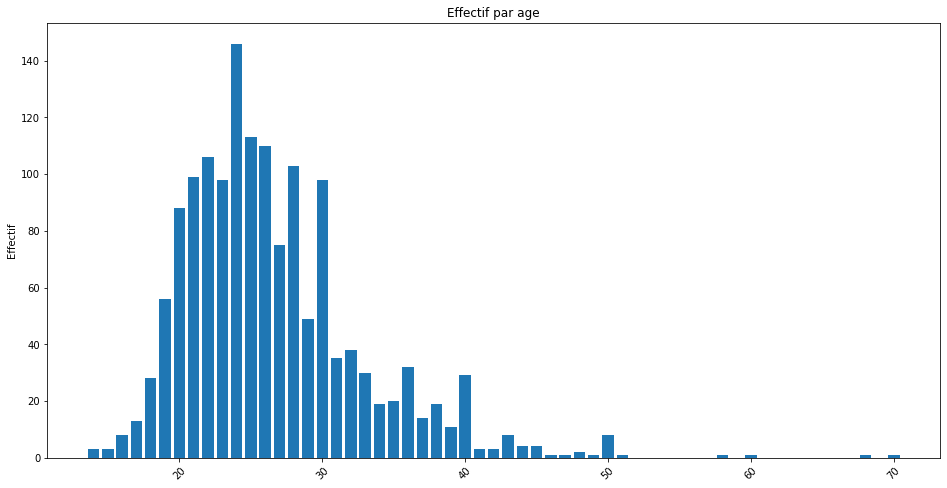

In [60]:
# Distribution par année

objects = [l for l in df_gb_pl_df.index][4:-1]
eff = [l for l in df_gb_pl_df['effectif']][4:-1]

p1 = plt.bar(objects, eff)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.title('Effectif par age')
plt.gcf().set_size_inches(16, 8)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


### à faire par FB: stacked bar par catégories

In [ ]:
### Regrouper (directement, sans passer par la liste) par continent et compter avec la fonction Pandas 'groupby'
gb_pl_df = pl_df[(pl_df['id_primo_processetto']>0)&(pl_df['genere']=='Femminile')].groupby('eta').size()
#gb_pl_df.sort_values(ascending = False)
gb_pl_df.sort_index()

In [ ]:
gb_pl_df = pl_df[(pl_df['id_primo_processetto']>0)].groupby(['eta', 'genere']).size()
gb_pl_df.iloc[50:70]

In [45]:
### Transformer l'objet Series en DataFrame et ajouter le nom de la colonne 'effectif'
# la colonne 'continent' est l'index : df_coded_nat.index
df_gb_pl_df = gb_pl_df.to_frame()
df_gb_pl_df.columns = ['effectif']
df_gb_pl_df = df_gb_pl_df.reset_index()

In [ ]:
df_gb_pl_df.iloc[50:80]

In [ ]:
df_gb_pl_df.values.tolist()

In [71]:
liste_ages = pd.RangeIndex(10, 71).to_series()
liste_ages.tail().values

array([66, 67, 68, 69, 70])

In [ ]:
for l in liste_ages[:10]:
    for e in df_gb_pl_df.values.tolist():
        if int(l) == int(e[0]) & e[1] == 'Maschile':
            print(e[2])

In [ ]:
liste_ages_genres = ['eta', 'maschile', 'femminile']
for l in liste_ages:
    for e in df_gb_pl_df.values.tolist():
        if l[0] == e[0] & e[1] == 'Maschile':
            m = e[2]
        else:
            m = 0
        if l[0] == e[0] & e[1] == 'Femminile':
            f = e[2]
        else:
            f = 0
        liste_ages_genres.append([l[0], m, f])    
    

In [ ]:
gb_pl_df.pivot(index=gb_pl_df.index, columns=['genere'])['effectif']

In [ ]:
df_gb_pl_df.set_index([df_gb_pl_df.index, 'genere'])['effectif','age'].unstack()

In [65]:
df_gb_pl_df.pivot_table(values=['eta','effectif'], index=df_gb_pl_df.index, columns='genere', aggfunc='first')

effectif                        eta                 
genere Femminile Maschile missing Femminile Maschile missing
0            1.0      NaN     NaN    -515.0      NaN     NaN
1            NaN      3.0     NaN       NaN      8.0     NaN
2            NaN      1.0     NaN       NaN      9.0     NaN
3            NaN      1.0     NaN       NaN     11.0     NaN
4            1.0      NaN     NaN      14.0      NaN     NaN
..           ...      ...     ...       ...      ...     ...
75           NaN      1.0     NaN       NaN     58.0     NaN
76           NaN      1.0     NaN       NaN     60.0     NaN
77           NaN      1.0     NaN       NaN     68.0     NaN
78           NaN      1.0     NaN       NaN     70.0     NaN
79           NaN      1.0     NaN       NaN    117.0     NaN

[80 rows x 6 columns]

In [ ]:
### Regrouper (directement, sans passer par la liste) par continent et compter avec la fonction Pandas 'groupby'
gb_pl_df = pl_df[pl_df['id_primo_processetto']>0].groupby('mestieri').size()
gb_pl_df.sort_values(ascending = False)
#gb_pl_df.sort_index()

In [ ]:
### Transformer l'objet Series en DataFrame et ajouter le nom de la colonne 'effectif'
# la colonne 'continent' est l'index : df_coded_nat.index
df_gb_pl_df = gb_pl_df.sort_values(ascending = False).to_frame()
df_gb_pl_df.columns = ['effectif']
df_gb_pl_df

In [ ]:
[[df_gb_pl_df.columns.tolist()] + df_gb_pl_df.reset_index().values.tolist()]

## Mettre 'à plat' le fichier – Préparation

Il s'agit de disposer de données agrégées afin de pouvoir effectuer plus facilement les analyses

In [14]:
### Person
[(r.col_0.entity.pk_entity, r.col_0.entity.entity_label) for r in dm_r[0:1]]


[(81417, 'Tommaso di Lorenzo Spilman (tedesco)')]

In [81]:
### Gender
# La première entrée est retenue (normalement il n'y en a pas plus)
[r.col_1.entities[0].entity_label if r.col_1 else 'missing' for r in dm_r[0:1]]

['Maschile']

In [83]:
### Origin
# Plusieurs origines son possibles pour une même personne : laquelle retenir ?
[[p.entity_label + '('+ str(p.pk_entity) +')' for p in r.col_5.entities] for r in dm_r[10:20]]

[['Modena(1083842)'],
 ['Costae diocesis Adriensis(1083910)'],
 [],
 ['Zurbao (1084309)'],
 ['Territorio di Milano(755887)', 'Rancio (1084720)'],
 ['Territorio di Udine(759336)'],
 ['Territorio di Brescia(768454)'],
 ['Ballobia (1084355)', 'Dioecesis Palentina(1084368)'],
 [],
 []]

In [84]:
### Occupation
# Plusieurs métiers sont possibles pour la même personne
[[p.entity_label + '('+ str(p.pk_entity) +')' for p in r.col_4.entities] for r in dm_r[40:50]]

[['mercante de panni (763128)'],
 ['boter(752920)'],
 [],
 ['portador da vin(748738)'],
 [],
 ['mariner(747734)', 'servir in bottega de luganegher (754028)'],
 ['pestriner(749677)', 'latter(749702)'],
 ['verghezin (748828)'],
 ['verghezin (748828)'],
 ['verghezin (748828)']]

In [ ]:
### Occupation
# Plusieurs métiers sont possibles pour la même personne
t1 = pd.DataFrame([[p.entity_label + '('+ str(p.pk_entity) +')' for p in r.col_4.entities][0] for r in dm_r if r.col_4.entities], columns=['occupation'])
t2 = t1.groupby('occupation').size()
t3 = t2.sort_values(ascending = False)
pd.DataFrame(t3,columns=['effectif']).reset_index().iloc[:50]

In [310]:
### Année de naissance
# Plusieurs années sont renseignées (ad quem, a quo) : la moyenne arrondie est retenue
for r in dm_r[36:40]:
    print(r.col_0.entity.pk_entity)
    values = []
    for v in r.col_2['values']:
        if v.value.timePrimitive:
            values.append(int(v.value.timePrimitive['from'].calGregorian[:4]))
    if len(values) > 1:
        print(int(round(np.rint(np.mean(values)))), values)
    elif len(values) > 0:    
        print(values[0])
    else:
        print(None)
    print('-----')       

747846
1527
-----
748299
1578 [1577, 1579]
-----
748322
1564 [1562, 1567]
-----
748378
1537
-----


In [ ]:
### Année processetto
for r in dm_r[50:60]:
    print(r.col_0.entity.pk_entity)
    values = []
    for v in r.col_7['values']:
        if v.value.timePrimitive:
            values.append(int(v.value.timePrimitive['from'].calGregorian[:4]))
    if len(values) > 1:
        print(int(round(np.rint(np.mean(values)))), values)
    elif len(values) > 0:    
        print(values[0])
    else:
        print(None)
    print('-----')       

In [ ]:
### Années union
# Plusieurs années sont renseignées (ad quem, a quo) : la moyenne arrondie est retenue
for r in dm_r[:500]:
    
    values = []
    for v in r.col_13['values']:
        if v.value.timePrimitive:
            values.append(int(v.value.timePrimitive['from'].calGregorian[:4]))
            values.append(int(v.value.timePrimitive['to'].calGregorian[:4]))
    if len(values) > 1:
        print(r.col_0.entity.pk_entity)
        print(int(round(np.rint(np.mean(values)))), values)
        print('-----')       
    elif len(values) > 0:  
        print(r.col_0.entity.pk_entity)
        print(values[0])
        print('-----')       
    else:
        pass
        # print(r.col_0.entity.pk_entity)
        # print(None)
        # print('-----')       

### Bouts de code à ranger ou éliminer

In [113]:
### Transformation en dictionnaire 
pl_dict = pl_df.to_dict('records')

In [358]:
str(pl_dict)[:1000]

"[{'id_persona': 81417, 'nome': 'Tommaso di Lorenzo Spilman (tedesco)', 'anno_nascita': 1558.0, 'genere': 'Maschile', 'luogo_origine': 'Alemania(753623)', 'mestieri': '', 'numero_processetti': 0, 'id_primo_processetto': 0, 'anno_primo_processetto': nan, 'tipo_primo_processetto': '', 'numero_testimonianze': 1, 'id_prima_testimonianza': 739330, 'anno_prima_testimonianza': 1592.0, 'tipo_prima_testimonianza': 'Stato libero di “foresto” #Processetto atipico ', 'date_unions': nan}, {'id_persona': 81461, 'nome': 'Gieremia Vais', 'anno_nascita': nan, 'genere': 'Maschile', 'luogo_origine': '', 'mestieri': '', 'numero_processetti': 0, 'id_primo_processetto': 0, 'anno_primo_processetto': nan, 'tipo_primo_processetto': '', 'numero_testimonianze': 0, 'id_prima_testimonianza': 0, 'anno_prima_testimonianza': nan, 'tipo_prima_testimonianza': '', 'date_unions': nan}, {'id_persona': 81648, 'nome': 'Limoletti, Domenico', 'anno_nascita': nan, 'genere': 'Maschile', 'luogo_origine': '', 'mestieri': '', 'num

### Gender

In [13]:
[r.col_1.entities[0].entity_label if r.col_1 else 'missing' for r in dm_r[0:5]]

['Maschile', 'Maschile', 'Maschile', 'Maschile', 'Maschile']

In [14]:
### gender list -> gl
gl = [r.col_1.entities[0].entity_label if r.col_1.entities else 'missing' for r in dm_r]
print(gl[101:107])
len(gl)

['Maschile', 'Maschile', 'Maschile', 'Maschile', 'Maschile', 'Maschile']


5608

In [15]:
D = dict(Counter(gl))
print(D)
len(D)

{'Maschile': 4935, 'Femminile': 636, 'missing': 37}


3

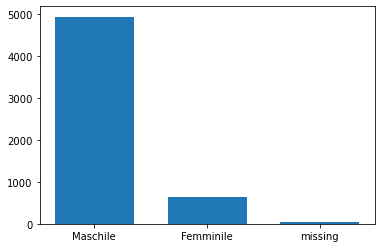

In [16]:
plt.bar(range(len(D)), list(D.values()), align='center', width=0.7)
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

## Age by category

In [ ]:
# [pprint.pprint(r) for r in rows[50:100]]

In [ ]:
def get_entities_JD(entities):
    result = []
    for e in entities:
        if e.time_span.p82.julianDay:
            result.append({'pk_teen' : e.pk_entity, 'JD' : e.time_span.p82.julianDay})
        elif e.time_span.p81a.julianDay:
            result.append({'pk_teen' : e.pk_entity, 'JD' : e.time_span.p81a.julianDay})
        elif e.time_span.p82a.julianDay:
            result.append({'pk_teen' : e.pk_entity, 'JD' : e.time_span.p82a.julianDay})
        else:
            result.append(None)

    return result

def get_entities_label(entities):
    result = []
    for e in entities:
        if e.entity_label:
            result.append(e.entity_label)
        else:
            result.append(None)

    return result

In [ ]:
ageOccupationProcessetto = []
for r in dm_r: #[299:303]:
    
    ## person identifier
    pk_entity = r.col_0.entity.pk_entity

    ## births
    birthsJD = get_entities_JD(r.col_3.entities)
    
    ## occupations, join the labels    
    occupations = ','.join([e.entity_label for e in r.col_10.entities])
    
    ## occupations, list 
    occupations_l = get_entities_label(r.col_10.entities)
    
    ## enquiries, get begin date
    enquiries = get_entities_JD(r.col_11.entities)

    ## witnesses, get begin date
    witnesses =  get_entities_JD(r.col_12.entities)
                
    ageOccupationProcessetto.append([pk_entity, birthsJD, occupations_l, enquiries, witnesses])               
    
    
    


In [ ]:
pprint.pprint(ageOccupationProcessetto[50:100])

In [ ]:
### age au moment du processetto et métier
dateBirthEnquiryOccupation = []
for l in ageOccupationProcessetto: #[50:70]:
    if l[1] and l[3]:
        if l[1][0] and l[3][0]:
            d = [jd.jd2jcal((l[1][0]['JD']),0)[0:3],jd.jd2jcal((l[3][0]['JD']),0)[0:3]]
            if l[2]:
                dateBirthEnquiryOccupation.append(d + [l[2]])
            else:    
                dateBirthEnquiryOccupation.append(d )
    else:
        dateBirthEnquiryOccupation.append(None)

    

In [ ]:
ages = [(y[1][0] - y[0][0]) for y in dateBirthEnquiryOccupation if y]
print(ages[:5])

In [ ]:
s_ages = pd.Series(ages)
s_ages.describe()

In [ ]:
std = s_ages.sort_values()
type(std)

In [ ]:
# agesCount
agesCount = pd.DataFrame(s_ages, columns=['column']).groupby(['column']).size()
# print(type(agesCount))
# agesCount.index

In [ ]:
ax = agesCount.plot.bar(x='lab', y='val', rot=70, figsize=(20,5))